In [1]:
! nvidia-smi

Sat Aug 15 02:09:32 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## LSTM

### 讀取資料

In [4]:
import pandas_datareader
dataset = pandas_datareader.get_data_yahoo('2330.TW', start = '2000-01-01')

In [5]:
dataset.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-04,69.649002,68.475197,69.649002,69.649002,2.006623e+11,37.032295
2000-01-05,71.214104,68.866302,69.649002,71.214104,4.024668e+11,37.864456
2000-01-06,71.214104,69.649002,70.822899,69.649002,1.975457e+11,37.032295
2000-01-07,68.475197,66.518600,67.301300,67.692497,2.352703e+11,35.992020
2000-01-10,70.431396,68.475197,69.649002,70.040199,2.761717e+11,37.240295


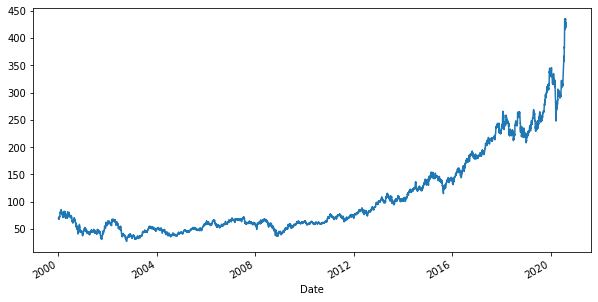

In [7]:
dataset['Close'].plot(kind = 'line', figsize = [10,5])

In [9]:
dataset = dataset[['Close']].values 

### 資料標準化

In [12]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled  = sc.fit_transform(dataset)

In [13]:
training_set_scaled

array([[0.10339779],
       [0.10723344],
       [0.10339779],
       ...,
       [0.95956295],
       [0.98407025],
       [0.97916879]])

In [14]:
len(training_set_scaled)

5079

In [17]:
import numpy as np
X_train = []
y_train = []
for i in range(60,len(training_set_scaled)):
  X_train.append(training_set_scaled[i-60:i,0])
  y_train.append(training_set_scaled[i,0])

In [18]:
X_train, y_train = np.array(X_train), np.array(y_train)

In [19]:
X_train.shape

(5019, 60)

In [21]:
X_train[0]

array([0.10339779, 0.10723344, 0.10339779, 0.09860293, 0.10435651,
       0.10147961, 0.1062747 , 0.10339779, 0.10723344, 0.11202828,
       0.10915136, 0.10915136, 0.10723344, 0.11106882, 0.112987  ,
       0.11778187, 0.1302475 , 0.13216568, 0.1283303 , 0.12737083,
       0.12641212, 0.12641212, 0.12641212, 0.12641212, 0.12641212,
       0.12641212, 0.13504261, 0.13791927, 0.14271438, 0.13791927,
       0.138878  , 0.13696079, 0.13504261, 0.13216568, 0.11969906,
       0.11969906, 0.11874034, 0.11969906, 0.12353544, 0.12353544,
       0.12545265, 0.1302475 , 0.12737083, 0.12737083, 0.12449393,
       0.12353544, 0.12257574, 0.12449393, 0.11969906, 0.10723344,
       0.11106882, 0.10819191, 0.10915136, 0.11490495, 0.10915136,
       0.11969906, 0.11682216, 0.12545265, 0.12257574, 0.13504261])

In [22]:
y_train.shape

(5019,)

In [23]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [24]:
X_train.shape

(5019, 60, 1)

(5019, 60, 1)

- 5019: 資料筆數
- 60: 時間的 sliding window
- 1: 特徵數量

### 建立模型

In [25]:
% tensorflow_version 2.x

In [26]:
import tensorflow as tf

In [27]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM, Dropout


In [28]:
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True)) 
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True)) 
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

In [30]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [ ]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

### 驗證模型

In [32]:
pred_y = regressor.predict(X_train)

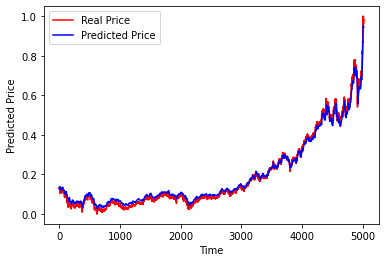

In [35]:

from matplotlib import pyplot as plt
plt.plot(y_train, color = 'red', label = 'Real Price')
plt.plot(pred_y, color = 'blue', label = 'Predicted Price')
plt.xlabel('Time')
plt.ylabel('Predicted Price')
plt.legend()
plt.show()

## 將資料分為訓練與測試資料集

In [36]:
len(training_set_scaled)

5079

In [42]:
import numpy as np
X_train = []
y_train = []
for i in range(60,4000):
  X_train.append(training_set_scaled[i-60:i,0])
  y_train.append(training_set_scaled[i,0])


X_test = []
y_test = []

for i in range(4000 - 60,len(training_set_scaled)):
  X_test.append(training_set_scaled[i-60:i,0])
  y_test.append(training_set_scaled[i,0])

In [43]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

In [44]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [46]:
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True)) 
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True)) 
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

In [ ]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(X_train, y_train, epochs = 20, batch_size = 32)

In [48]:
pred_y = regressor.predict(X_test)

In [51]:
pred_y.shape

(1139, 1)

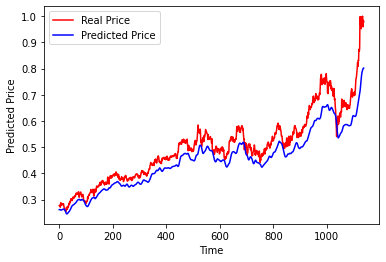

In [49]:

from matplotlib import pyplot as plt
plt.plot(y_test, color = 'red', label = 'Real Price')
plt.plot(pred_y, color = 'blue', label = 'Predicted Price')
plt.xlabel('Time')
plt.ylabel('Predicted Price')
plt.legend()
plt.show()

In [55]:
y_real_test = sc.inverse_transform(y_test.reshape(-1,1)).flatten()

In [56]:
y_real_pred = sc.inverse_transform(pred_y.reshape(-1,1)).flatten()

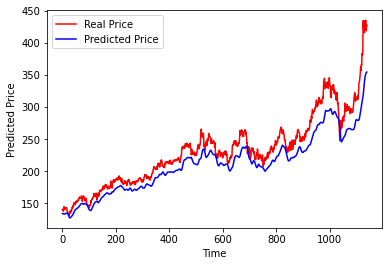

In [57]:

from matplotlib import pyplot as plt
plt.plot(y_real_test, color = 'red', label = 'Real Price')
plt.plot(y_real_pred, color = 'blue', label = 'Predicted Price')
plt.xlabel('Time')
plt.ylabel('Predicted Price')
plt.legend()
plt.show()